Download

In [1]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("google-research-datasets/wiki_atomic_edits", 'english_insertions')

# Select only the first 1,000 samples
subset = dataset["train"].select(range(1000))

# Specify the save path
save_path = "english_insertions"

# Save the dataset to the specified directory
dataset.save_to_disk(save_path)

print(f"Dataset saved to {save_path}")


/home/longnhat/miniconda3/envs/icl_mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (9/9 shards): 100%|██████████| 13737796/13737796 [00:03<00:00, 4454778.14 examples/s]

Dataset saved to english_insertions


Load

In [1]:
from datasets import load_from_disk

# Load the dataset from disk
subset = load_from_disk("english_insertions")
print(subset)


DatasetDict({
    train: Dataset({
        features: ['id', 'base_sentence', 'phrase', 'edited_sentence'],
        num_rows: 13737796
    })
})


Construct prompt

In [2]:
prompt_list = []

from tqdm import tqdm
base_sents = subset['train']['base_sentence']
phrases = subset['train']['phrase']
edited_sents = subset['train']['edited_sentence']

Test

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 XL tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl')
model.to(device)
model.eval()

/home/phu.hoang/.conda/envs/copy_mech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [2]:
model.config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 50257
}

In [4]:
import string
from tqdm import tqdm
import numpy as np

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

def preprocessing(text):
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Remove multiple whitespaces
    text = ' '.join(text.split())
    return text

# function to calculate jaccard of two sets
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union

def encode_decode(text, cuda = False, return_ids = False):
    if cuda:
        input_ids = tokenizer.encode(text, return_tensors='pt').to(device)
    else:
        input_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = input_ids[0].tolist()
    decoded_tokens = [tokenizer.decode([token]) for token in tokens]

    if return_ids:
        return decoded_tokens, input_ids
    else:   
        return decoded_tokens

def is_punctuation(token):
    # Consider tokens that are punctuation marks or empty spaces
    return token.strip() in string.punctuation or token.strip() == '' or token.strip() == '\n'

def get_tokens_without_punctuation(tokens):
    tokens_no_punct = []
    indices = []
    for idx, token in enumerate(tokens):
        if not is_punctuation(token):
            tokens_no_punct.append(token)
            indices.append(idx)
    return tokens_no_punct, indices

def find_token_indices(base_tokens, edited_tokens, base_indices, edited_indices):
    matching_indices = []
    edited_pos = 0
    for base_idx, base_token in zip(base_indices, base_tokens):
        found = False
        base_token_stripped = base_token.strip()
        while edited_pos < len(edited_tokens):
            edited_token_stripped = edited_tokens[edited_pos].strip()
            if base_token_stripped == edited_token_stripped:
                matching_indices.append(edited_indices[edited_pos])
                edited_pos += 1
                found = True
                break
            else:
                edited_pos += 1
        if not found:
            return False
    return matching_indices

def find_base_sent(base_sent, prompt):
    base_sentence = encode_decode(base_sent)
    edited_sentence, edited_ids = encode_decode(prompt, cuda=True, return_ids=True)

    # print(f"base: {base_sentence}")
    # print(f"edited: {edited_sentence}")

    # Get tokens and indices without punctuation from base sentence
    base_tokens_no_punct, base_indices_no_punct = get_tokens_without_punctuation(base_sentence)

    idx = len(base_sentence) + 4
    realign_edited_sentence = edited_sentence[:idx]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_1st = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    idx = len(base_sentence) + 3
    realign_edited_sentence = edited_sentence[idx:]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_2nd = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    if matching_indices_1st == False or matching_indices_2nd == False:
        return False, False, False, False

    # add idx to the indices 2nd
    matching_indices_2nd = [i + idx for i in matching_indices_2nd]

    return matching_indices_1st, matching_indices_2nd, edited_ids, edited_sentence

In [5]:
import torch
import numpy as np
from tqdm import tqdm

def get_top_k(logits, top_k, tokenizer):
    prob = torch.softmax(logits, dim=-1)
    top_tokens = torch.topk(prob, top_k, dim=-1)
    tokens = [tokenizer.decode([idx.item()]) for idx in top_tokens.indices[0]]
    return tokens

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

n = 5    # For n=1, should closely resemble Code A's behavior
skiped = 0
top_k = 10
jc_ult = []
first_pred_ult = []

for i in tqdm(range(1000)):
    base_sent = preprocessing(base_sents[i])
    phrase = preprocessing(phrases[i])
    edited_sent = preprocessing(edited_sents[i])

    prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

    # Find indices in edited sentence
    matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = find_base_sent(base_sent, prompt)
    if matching_indices_1st == False or matching_indices_2nd == False:
        skiped += 1
        continue

    # Prepare dictionary for predictions:
    # Each step will have its own dictionary: {'adjusted': [...], 'original': [...]}
    dict_pred = {step: {} for step in range(n)}

    # Define hook for adjusted run
    def adjust_hidden_states(module, inp, output):
        hidden_states = output[0]
        # Copy hidden states from first to second occurrence
        hidden_states[:, matching_indices_2nd, :] = hidden_states[:, matching_indices_1st, :]
        return (hidden_states,) + output[1:]

    # Register hooks for adjusted run
    hooks = []
    for idx, block in enumerate(model.transformer.h):
        hook = block.register_forward_hook(adjust_hidden_states)
        hooks.append(hook)

    # Run adjusted model generation
    adjusted_generated_ids = input_ids.clone()
    for step in range(n):
        with torch.no_grad():
            outputs_adjusted = model(adjusted_generated_ids)
            logits_adjusted = outputs_adjusted.logits
            next_token_logits_adjusted = logits_adjusted[:, -1, :]
            adjusted_tokens = get_top_k(next_token_logits_adjusted, top_k, tokenizer)

        dict_pred[step]['adjusted'] = adjusted_tokens

        # Greedy decoding for next token
        next_token_id_adjusted = torch.argmax(next_token_logits_adjusted, dim=-1, keepdim=True)
        adjusted_generated_ids = torch.cat([adjusted_generated_ids, next_token_id_adjusted], dim=-1)

    # Remove hooks after adjusted run
    for hook in hooks:
        hook.remove()

    # Run original model generation (no hooks)
    original_generated_ids = input_ids.clone()
    for step in range(n):
        with torch.no_grad():
            outputs_original = model(original_generated_ids)
            logits_original = outputs_original.logits
            next_token_logits_original = logits_original[:, -1, :]
            original_tokens = get_top_k(next_token_logits_original, top_k, tokenizer)

        dict_pred[step]['original'] = original_tokens

        # Greedy decoding for next token
        next_token_id_original = torch.argmax(next_token_logits_original, dim=-1, keepdim=True)
        original_generated_ids = torch.cat([original_generated_ids, next_token_id_original], dim=-1)

    # Compute metrics for each token step
    jc_scores = []
    first_predictions = []
    for step in range(n):
        adjusted_tokens = dict_pred[step]['adjusted']
        original_tokens = dict_pred[step]['original']
        jaccard_sim = jaccard_similarity(adjusted_tokens, original_tokens)
        jc_scores.append(jaccard_sim)
        first_predictions.append(int(adjusted_tokens[0] == original_tokens[0]))

    # Append results
    # For n=1, jc_scores and first_predictions each contain a single value
    # jc_ult.append(sum(jc_scores) / len(jc_scores))
    # first_pred_ult.append(sum(first_predictions) / len(first_predictions))
    jc_ult.append(jc_scores)
    first_pred_ult.append(first_predictions)

# # Calculate and print mean metrics
# mean_jc = sum(jc_ult) / len(jc_ult) if jc_ult else 0
# mean_first_pred = sum(first_pred_ult) / len(first_pred_ult) if first_pred_ult else 0

# print(f"Mean Jaccard similarity: {mean_jc}")
# print(f"Mean first prediction: {mean_first_pred}")


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


In [7]:
jc_ult

[[0.6666666666666666,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182],
 [0.6666666666666666,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182],
 [0.5384615384615384,
  0.8181818181818182,
  0.6666666666666666,
  1.0,
  0.8181818181818182],
 [0.6666666666666666,
  0.5384615384615384,
  0.6666666666666666,
  0.8181818181818182,
  0.8181818181818182],
 [0.42857142857142855,
  0.5384615384615384,
  0.8181818181818182,
  0.8181818181818182,
  0.6666666666666666],
 [0.6666666666666666,
  0.8181818181818182,
  0.6666666666666666,
  0.8181818181818182,
  0.8181818181818182],
 [0.8181818181818182,
  1.0,
  0.8181818181818182,
  0.6666666666666666,
  0.8181818181818182],
 [1.0, 1.0, 0.8181818181818182, 1.0, 1.0],
 [0.6666666666666666,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  1.0],
 [0.8181818181818182, 1.0, 1.0, 0.8181818181818182, 1.0],
 [0.35714285714285715,
  0.8181818181818182,
  0.818181

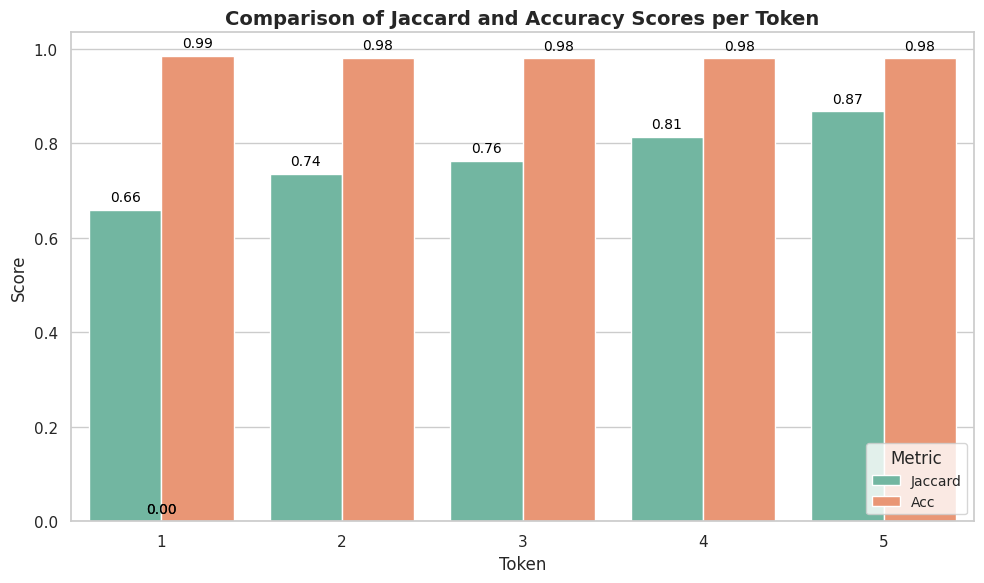

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_mean(arr):
    arr_np = np.array(arr)
    return arr_np.mean(axis=0)

# Example data (replace with actual jc_ult and first_pred_ult)
jaccard = compute_mean(jc_ult)
acc = compute_mean(first_pred_ult)

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Token': np.arange(len(jaccard)) + 1,  # Token IDs starting from 1
    'Jaccard': jaccard,
    'Acc': acc
})

# Melt the DataFrame to a long format suitable for Seaborn
data_melted = data.melt(id_vars='Token', value_vars=['Jaccard', 'Acc'], 
                        var_name='Metric', value_name='Score')

# Set a modern style and define custom colors
sns.set_theme(style='whitegrid')
palette = sns.color_palette("Set2", 2)  # Define a color palette

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Token', y='Score', hue='Metric', data=data_melted, palette=palette)

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # Format to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on top of the bar
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4), textcoords='offset points')

# Add a title and labels
plt.title('Comparison of Jaccard and Accuracy Scores per Token', fontsize=14, fontweight='bold')
plt.xlabel('Token', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Adjust legend
plt.legend(title='Metric', loc='lower right', fontsize=10, title_fontsize=12)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()
